# Media Mix Modeling: How to Measure the Effectiveness of Advertising with Python & LightweightMMM
Media Mix modeling, its implementation, and practical tips

For more details, see the [full article](https://towardsdatascience.com/media-mix-modeling-how-to-measure-the-effectiveness-of-advertising-with-python-lightweightmmm-b6d7de110ae6)

First, let’s install the lightweight_mmm library using pip command. It should take about 1–2 minutes. If you get the error “restart runtime”, you need to click the “restart runtime” button.

In [ ]:
# !pip install --upgrade git+https://github.com/google/lightweight_mmm.git

Also, let’s import some libraries such as JAX, numpryro, and necessary modules of the library.

In [1]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro


# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

/mnt/c/Users/rafael.machado_dp6/Documents/Estudos/lightweight_mmm/tutorial_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-16 15:54:38.834991: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 15:55:12.772219: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-16 15:55:12.775191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open

Next, let’s prepare the data. The official sample script uses a simulated data set that is generated by the library’s function to create dummy data. However, I’m going touse more realistic data in this session. I found a good dataset on a GitHub repository: sibylhe/mmm_stan. I am not sure whether this data set is real, dummy, or simulated data, but for me, it looks more realistic than any other data I found on the internet.

In [2]:
import pandas as pd

# I am not sure whether this data set is real, dummy, or simulated data, but for me, it looks more realistic than any other data I found on the internet.
df = pd.read_csv("https://raw.githubusercontent.com/sibylhe/mmm_stan/main/data.csv")

# 1. media variables
# media spending (Simplified media channel for demo)
mdsp_cols=[col for col in df.columns if 'mdsp_' in col and col !='mdsp_viddig' and col != 'mdsp_auddig' and col != 'mdsp_sem']

# 2. control variables
# holiday variables
hldy_cols = [col for col in df.columns if 'hldy_' in col]
# seasonality variables
seas_cols = [col for col in df.columns if 'seas_' in col]

control_vars =  hldy_cols + seas_cols

# 3. sales variables
sales_cols =['sales']

df_main = df[['wk_strt_dt']+sales_cols+mdsp_cols+control_vars]
df_main = df_main.rename(columns={'mdsp_dm': 'Direct Mail', 'mdsp_inst': 'Insert', 'mdsp_nsp': 'Newspaper', 'mdsp_audtr': 'Radio', 'mdsp_vidtr': 'TV', 'mdsp_so': 'Social Media', 'mdsp_on': 'Online Display'})
mdsp_cols = ["Direct Mail","Insert", "Newspaper", "Radio", "TV", "Social Media", "Online Display"]

Let’s take a quick look at it. This data contains four years of records of data at a weekly level. For simplicity, I use seven media channels for media spending data, and holiday and seasonal information for control variables.

In [3]:
df_main.head()

,wk_strt_dt,sales,Direct Mail,Insert,Newspaper,Radio,TV,Social Media,Online Display,hldy_Black Friday,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,2014-08-03,72051457.64,678410.26,129759.66,507635.16,254134.14,216725.59,0.0,61364.75,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,78794770.54,661097.71,70355.33,625719.37,106602.98,108919.26,0.0,132643.90,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,70071185.56,1874338.43,107720.37,277532.61,59011.42,74032.19,0.0,76741.27,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,68642464.59,306583.37,141708.61,186028.61,178010.46,110995.66,0.0,193043.55,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,86190784.65,2366274.16,160691.30,706694.09,144097.56,225140.84,0.0,249612.89,0,...,0,0,0,0,0,0,0,0,0,0


Next, I’m going to preprocess the data. We split the dataset into train and test. I’m leaving only the last 24 weeks for testing in this case.

In [4]:
SEED = 105
data_size = len(df_main)

n_media_channels = len(mdsp_cols)
n_extra_features = len(control_vars)
media_data = df_main[mdsp_cols].to_numpy()
extra_features = df_main[control_vars].to_numpy()
target = df_main['sales'].to_numpy()
costs = df_main[mdsp_cols].sum().to_numpy()

# Split and scale data.
test_data_period_size = 24
split_point = data_size - test_data_period_size
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

Also, this library provides a CustomScaler function for preprocessing. In this sample code, we divide the media spending data, extra features data, and the target data by their mean to ensure that the result has a mean of 1. This allows the model to be agnostic to the scale of the inputs.

In [5]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


The next step is training. We can choose an ad stock function for the modeling from 3 options: Hill-ad stock, Ad stock, and carryover. It is generally recommended to compare all three approaches, and use the approach that works the best.

In [6]:
number_warmup, number_samples = 1000, 1000 # 1000 is the default value for both parameters.
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")
mmm.fit(
    media=media_data_train, 
    media_prior=costs, 
    target=target_train, 
    extra_features=extra_features_train, 
    number_warmup=number_warmup, 
    number_samples=number_samples, 
    media_names = mdsp_cols, 
    seed=SEED
)

/mnt/c/Users/rafael.machado_dp6/Documents/Estudos/lightweight_mmm/tutorial_env/lib/python3.8/site-packages/lightweight_mmm/lightweight_mmm.py:357: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [01:35<00:00, 20.97it/s, 1023 steps of size 1.76e-03. acc. prob=0.93]


Once training is finished, you can check the summary of your trace: The important point here is to check whether r hat values for all parameters are less than 1.1. This is a checkpoint when you run Bayesian modeling.

In [7]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.04      0.84      0.05     -1.39      1.35    391.89      1.00
             coef_extra_features[1]      0.11      0.70      0.13     -1.04      1.22    255.42      1.00
             coef_extra_features[2]     -0.01      0.01     -0.01     -0.02     -0.00    356.33      1.01
             coef_extra_features[3]      0.00      0.00      0.00     -0.00      0.01    709.21      1.01
             coef_extra_features[4]     -0.05      0.71     -0.06     -1.23      1.11    279.89      1.00
             coef_extra_features[5]     -0.09      0.70     -0.12     -1.21      1.06    256.11      1.00
             coef_extra_features[6]     -0.01      0.00     -0.01     -0.01     -0.00   1263.26      1.00
             coef_extra_features[7]     -0.00      0.00     -0.00     -0.01      0.00    877.85      1.00
             coef_extra_features[8]     -0.02

We can visualize the posterior distributions of the media effects.

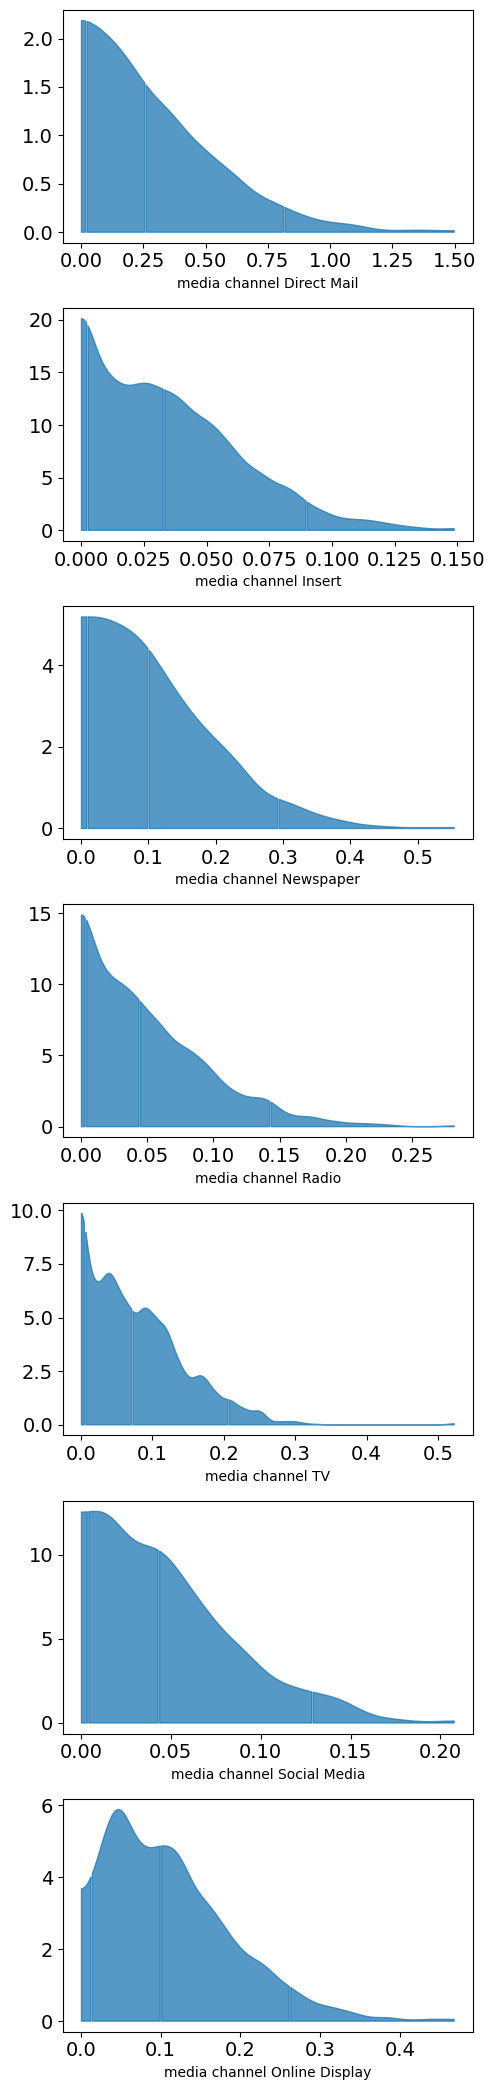

In [8]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=mdsp_cols)

Now, let’s do a fitting check. The model’s fit to the training data can also be checked by using plot_model_fit function. R-squared and MAPE, mean absolute percentage error, are shown in the chart. In this example, R2 is 0.9, and MAPE is 23%. Generally speaking, R2 is considered good if it is more than 0.8. Also, for MAPE, the goal is for it to be 20% or below.

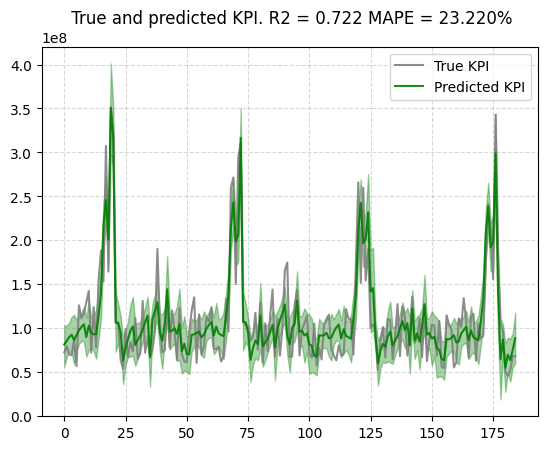

In [9]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

And this is the visualization of the prediction result. R2 is 0.62, and MAPE is 23%. Honestly, the R2 and MAPE values here are not ideal. However, I do not have any additional data, and — I’m not even sure — whether this data set is real or a dummy. That said, I’m still going to be using — this data set and modeling — to show you the insights. I’ll be going over how to improve the model in more detail later.

In [10]:
new_predictions = mmm.predict(media=media_data_test,
                              extra_features=extra_features_test,
                              target_scaler=target_scaler)

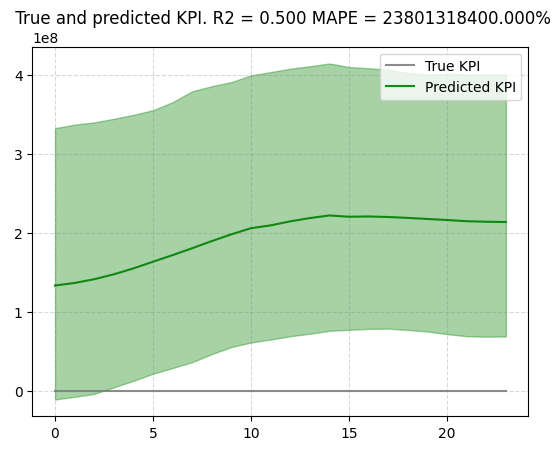

In [11]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                  out_of_sample_target=target_scaler.transform(target[split_point:]))

#### Outcomes
We can quickly visualize the estimated media & baseline contribution over time by using this function. The graph below shows that about 70% of sales are baseline sales, which is represented by the blue area. The other colors show media contribution to the remaining sales.

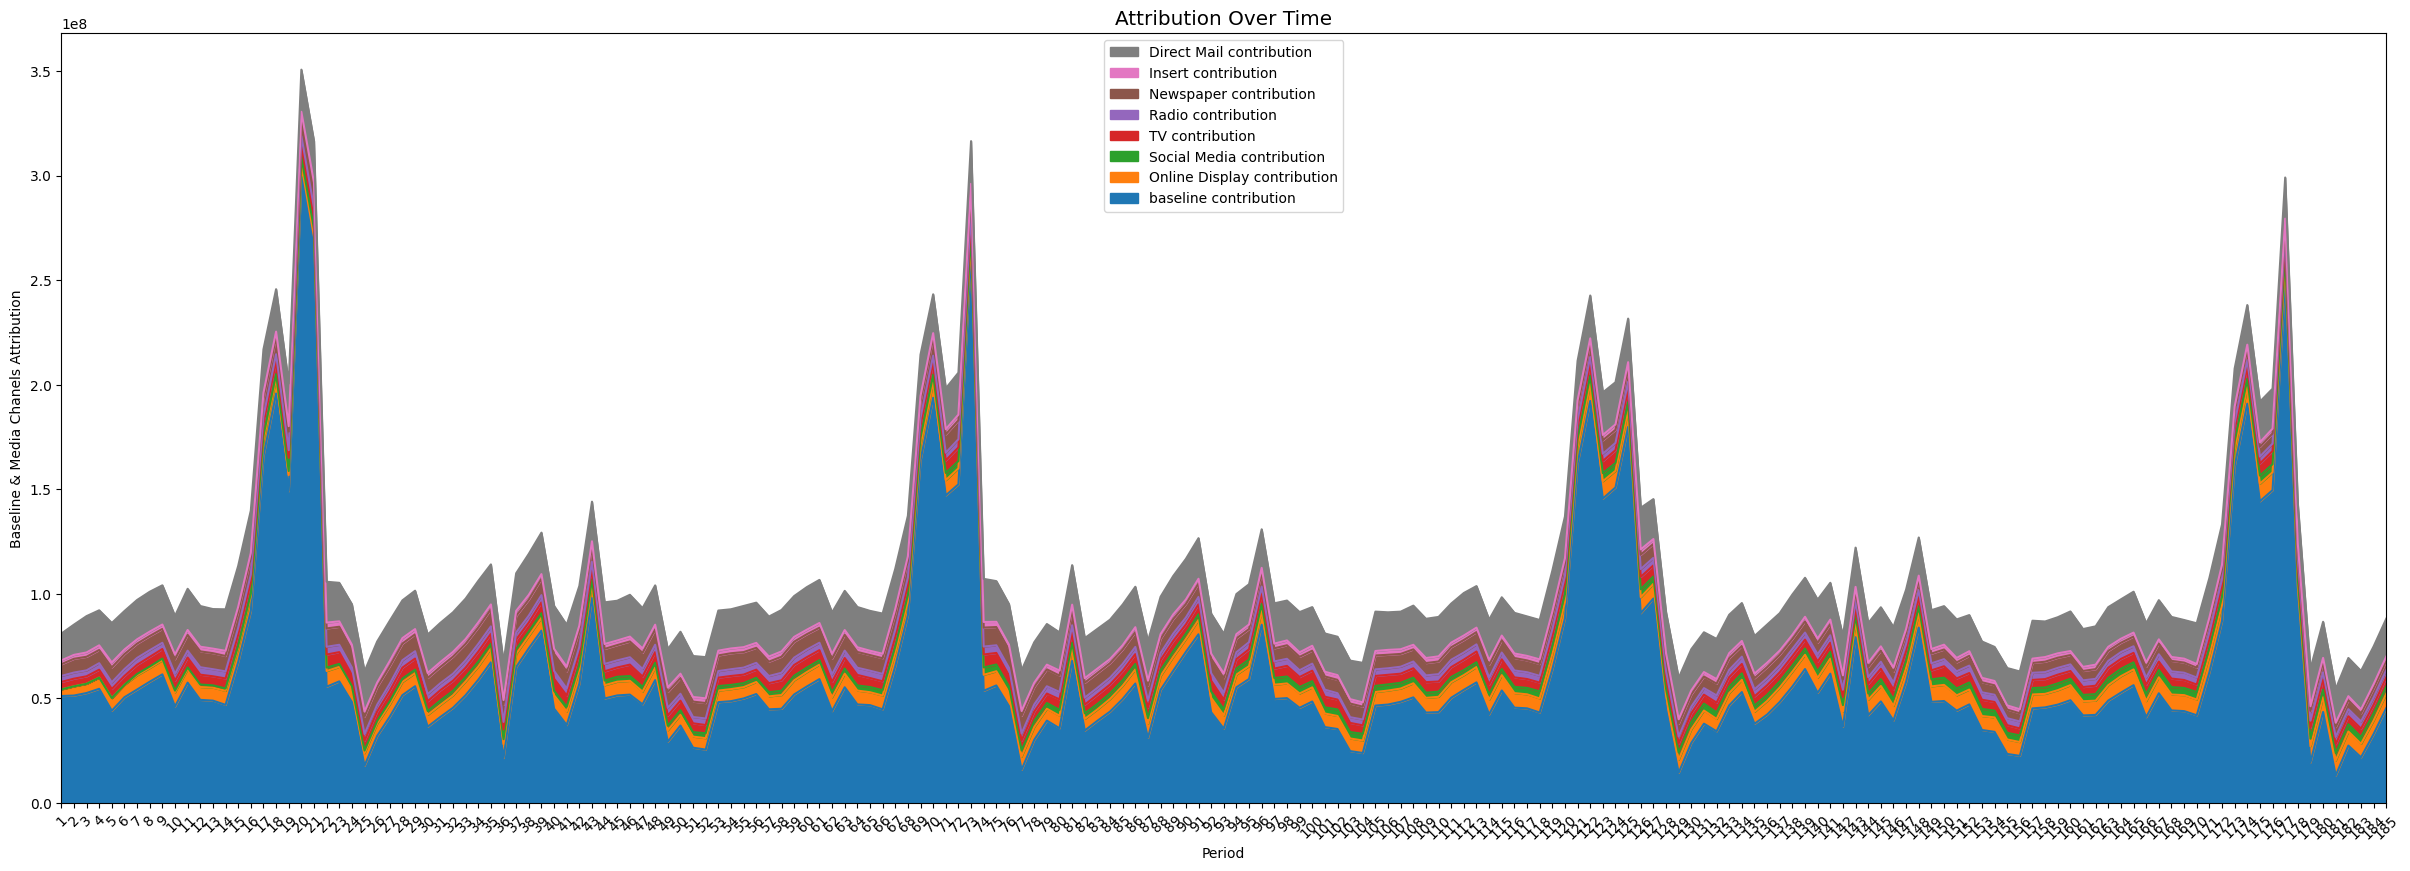

In [12]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),
                                                channel_names = mdsp_cols
                                                )

This graph shows the estimated ROI of each media channel. Each bar represents how efficient the ROI of the media is. In this case, TV and Online Display are more efficient than other media.

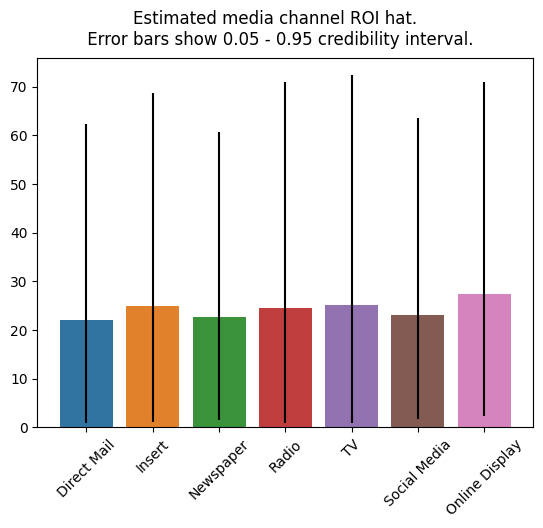

In [13]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=mdsp_cols)

We can visualize the optimized media budget allocation. The graph shows the previous budget allocation and optimized budget allocation. In this case, direct mail and radio should be reduced, and other media should be increased.

In [ ]:
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10),
                                                channel_names = mdsp_cols)